# Retail Sales Forecasting

This notebook presents a complete data science understanding. The project focuses on forecasting weekly sales for a retail chain using historical sales data, store characteristics, and external factors.

## Problem Definition & Business Understanding

- **Objective:** Forecast weekly sales and understand key drivers (e.g., markdown promotions, holidays, economic factors) affecting sales performance.
- **Key Questions:**
  - What factors (store type, markdowns, holidays, economic indicators) drive sales?
  - How do promotional markdowns impact weekly sales?
  - Can we predict future sales accurately using historical data?
- **Success Metrics:** R², and actionable insights for decision making.

### Import necessary Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings 
warnings.filterwarnings('ignore') 

## Data Integration

We have three datasets:

1. **features.csv**: Contains environmental and economic data (Temperature, Fuel_Price, CPI, Unemployment, MarkDowns, and IsHoliday).
2. **train.csv**: Contains weekly sales data (Store, Dept, Date, Weekly_Sales, IsHoliday).
3. **stores.csv**: Contains store characteristics (Store, Type, Size).

The datasets are merged using common keys (Store) to produce a final dataset for analysis. In this notebook, we assume the merged dataset is available as `df`.

In [2]:
features = pd.read_csv("features.csv.xls")

In [3]:
features.shape

(8190, 12)

**In Features has 8190 rows and 12 columns**

In [4]:
stores = pd.read_csv("stores.csv.xls")

In [5]:
stores.shape

(45, 3)

**In Store has 45 rows and 3 columns**

In [6]:
train = pd.read_csv("train.csv.xls")

In [7]:
train.shape

(421570, 5)

**In train has 421570 rows and 5 columns**

In [8]:
# Merge train with features on 'Store'
df = pd.merge(train, features, how="inner")

In [9]:
# Merge the result with stores on 'Store'
df = pd.merge(df, stores, on="Store", how="inner")

In [10]:
df.shape

(421570, 16)

**df DataFrame has 421570 and 16 rows in initial phase**

In [11]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


**<pre>Bool Datatype: IsHoliday
Object Dataype: Type
Date type: Date 
Nulls: All MarkDown</pre>**

## Data Cleaning & Preprocessing

- **Convert data types** (e.g., ensure the Date column is datetime).
- **Check for missing values** and handle them appropriately (e.g., fill missing markdowns with 0 if no discount was applied).

In [13]:
# Convert the Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [14]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

**Most missing values are likely in MarkDown columns.**

In [15]:
df[['MarkDown1', 'MarkDown2','MarkDown3','MarkDown4','MarkDown5']].isnull().sum().mean()

284486.2

**Around 284486 Weeks are not any MarkDown scheme is apply**

In [16]:
# fill the nulls whit 0
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(0)

In [17]:
df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [18]:
df = df.loc[df['Weekly_Sales'] > 0]

- Keep only positive values

## Exploratory Data Analysis (EDA)
We perform univariate, bivariate, and multivariate analyses along with computing central tendency, skewness, kurtosis, covariance, and correlation.

In [19]:
num_columns_means = df.select_dtypes(include=np.number).mean()
num_columns_means

Store               22.195611
Dept                44.241309
Weekly_Sales     16033.114591
Temperature         60.090599
Fuel_Price           3.360890
MarkDown1         2590.323565
MarkDown2          878.905242
MarkDown3          468.845949
MarkDown4         1083.534361
MarkDown5         1662.805002
CPI                171.212496
Unemployment         7.960000
Size            136749.732787
dtype: float64

**Markdown Campaigns Influence Sales**

- High mean for MarkDown1 and MarkDown5 suggests significant promotions.

- Lower values like MarkDown3 may be removed if they show no meaningful pattern.

**Moderate Weekly Sales Baseline**

- With an average of ₹16,033 in weekly sales, this can be used to flag above-average performing stores/departments for strategic focus.

**Store Size Matters**

- Larger stores (mean ~136,750 sq ft) likely handle more departments and products, so sales should be normalized per sq ft for fair comparison.

**Weather and Sales**

- Avg. temp ~60°F means weather-related demand may exist (seasonal items).



In [20]:
num_columns_median = df.select_dtypes(include=np.number).median()
num_columns_median

Store               22.000000
Dept                37.000000
Weekly_Sales      7661.700000
Temperature         62.090000
Fuel_Price           3.452000
MarkDown1            0.000000
MarkDown2            0.000000
MarkDown3            0.000000
MarkDown4            0.000000
MarkDown5            0.000000
CPI                182.350989
Unemployment         7.866000
Size            140167.000000
dtype: float64

**Zero-Heavy Markdown Columns**

- Majority of rows have no markdowns.


In [21]:
mode_values = df.mode().iloc[0]
mode_values

Store                          13.0
Dept                              1
Date            2011-12-23 00:00:00
Weekly_Sales                   10.0
IsHoliday                     False
Temperature                   50.43
Fuel_Price                    3.638
MarkDown1                       0.0
MarkDown2                       0.0
MarkDown3                       0.0
MarkDown4                       0.0
MarkDown5                       0.0
CPI                      129.855533
Unemployment                  8.099
Type                              A
Size                        39690.0
Name: 0, dtype: object

- Store 13 appears most often — possibly has more transactions/data or is a central store.
- Dept 1 is the most common — might be a core product line or essential department.
- Peak activity around Christmas — strong holiday sales impact.
- As expected — holidays are rare events.
- Most stores are Type A — larger format possibly.
- Sales is unexpectedly low, indicating a large number of low-sales.

## Combined Statistical Summary of Key Features

| Feature        | Mean           | Median         | Mode           | Insight |
|----------------|----------------|----------------|----------------|---------|
| **Store**       | 22.20          | 22.00          | 13.0           | Store 13 has the most entries, average store is mid-range. |
| **Dept**        | 44.24          | 37.00          | 1              | Department 1 is most common — likely a top-selling or general category. |
| **Weekly_Sales**| 16,033.11      | 7,661.70       | 10.0           | Highly skewed data, with many low/zero sales. |
| **Temperature** | 60.09°F        | 62.09°F        | 50.43°F        | Mostly moderate temperatures, mode suggests winter/fall season. |
| **Fuel_Price**  | 3.36           | 3.45           | 3.638          | Relatively stable fuel prices. |
| **MarkDown1**   | 2590.32        | 0.00           | 0.0            | Majority of values are zero, with a few very high markdowns. |
| **MarkDown2**   | 878.91         | 0.00           | 0.0            | Zero-inflated; most entries had no markdown. |
| **MarkDown3**   | 468.85         | 0.00           | 0.0            | Same pattern as above. |
| **MarkDown4**   | 1083.53        | 0.00           | 0.0            | Outlier-heavy, few high-value discounts. |
| **MarkDown5**   | 1662.81        | 0.00           | 0.0            | Consider binary transformation. |
| **CPI**         | 171.21         | 182.35         | 129.86         | Skewed — possibly reflects inflation over multiple years. |
| **Unemployment**| 7.96%          | 7.87%          | 8.10%          | Stable unemployment; slight skew. |
| **Size**        | 136,749        | 140,167        | 39,690         | Most stores are much smaller than the average — consider segmentation. |


In [22]:
df.drop(['MarkDown2','MarkDown3'], axis=1, inplace = True)

In [23]:
df.drop(['Date','Type'], axis=1).skew()

Store           0.077947
Dept            0.359016
Weekly_Sales    3.258942
IsHoliday       3.360255
Temperature    -0.321295
Fuel_Price     -0.104678
MarkDown1       4.730933
MarkDown4       8.075125
MarkDown5       9.952112
CPI             0.084673
Unemployment    1.183789
Size           -0.326689
dtype: float64

**Skewness Insights**

**Weekly_Sales → 3.26**

- Highly right-skewed → many lower sales with few extremely high ones.

- MarkDown1 to MarkDown5 → Very high skew (3 to 8)

- Highly positively skewed, indicating most values are 0 with rare high markdowns.

**IsHoliday → 3.36**

- Skewed towards non-holiday (False) entries, few holiday entries.

**Unemployment → 1.18**

- Slight right skew → majority low values with few high unemployment rates.

**Temperature & Size → Slight negative skew (~ -0.32)**

- Mild left skew, values are slightly more concentrated at higher end.

**Fuel_Price & CPI → Near zero skew**

- Symmetrical distribution, normally spread.

In [24]:
df['Weekly_Sales'] = np.log(df['Weekly_Sales'])

In [25]:
cols = ['MarkDown1', 'MarkDown4', 'MarkDown5']

for col in cols:
    df[col] = np.log1p(df[col])

- Compresses large values
- Log(0) is undefined, but log1p(0) = 0

In [26]:
df.drop(['Date','Type'], axis=1).skew()

Store           0.077947
Dept            0.359016
Weekly_Sales   -1.305715
IsHoliday       3.360255
Temperature    -0.321295
Fuel_Price     -0.104678
MarkDown1       0.725909
MarkDown4       0.987060
MarkDown5       0.640268
CPI             0.084673
Unemployment    1.183789
Size           -0.326689
dtype: float64

In [27]:
df['Weekly_Sales'].isna().sum()

0

In [28]:
df = df.dropna()

In [29]:
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [30]:
df.drop(['Date','Type'], axis=1).kurt()

Store          -1.146698
Dept           -1.216644
Weekly_Sales    2.221197
IsHoliday       9.291355
Temperature    -0.636128
Fuel_Price     -1.185445
MarkDown1      -1.357072
MarkDown4      -0.811160
MarkDown5      -1.518561
CPI            -1.829848
Unemployment    2.729259
Size           -1.206400
dtype: float64

## Kurtosis Insights

 1. Highly Leptokurtic Variables (> 3)
- **IsHoliday (7)**:
  - Extreme kurtosis indicates binary data with severe imbalance

 2. Moderately Leptokurtic Variables (2-3)
- **MarkDown1 (2.0)**  
  - These show heavier tails than normal:


### Univariate Analysis

In [31]:
numerical_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

In [32]:
sample_size = 10000  # Adjust as needed
df_sampled = df.sample(n=min(sample_size, len(df)), random_state=42) # Ensure you don't sample more than the total rows
df_sampled

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
49544,6,6,2010-11-12,9.207494,False,62.11,2.728,0.000000,0.000000,0.000000,213.526801,7.007,A,202505
87526,10,1,2010-02-19,10.814732,False,58.22,2.915,0.000000,0.000000,0.000000,126.526286,9.765,B,126512
295158,31,11,2010-07-23,9.390960,False,87.17,2.608,0.000000,0.000000,0.000000,210.892132,8.099,A,203750
164171,17,56,2012-04-27,8.921515,False,59.11,3.842,7.514178,2.296567,7.701829,131.126667,6.235,B,93188
62726,7,29,2010-03-05,7.079184,False,35.86,2.620,0.000000,0.000000,0.000000,189.669505,9.014,B,70713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358776,38,74,2012-07-20,6.457115,False,85.53,3.726,4.331260,0.000000,7.156917,130.701290,10.926,C,39690
347694,37,9,2011-01-14,4.010419,False,42.87,2.983,0.000000,0.000000,0.000000,210.237973,8.395,C,39910
315095,33,9,2010-08-13,1.057790,False,95.57,3.049,0.000000,0.000000,0.000000,126.064000,9.495,A,39690
57521,6,85,2012-08-31,7.403847,False,83.58,3.638,9.989773,9.659949,8.294947,223.921012,5.668,A,202505


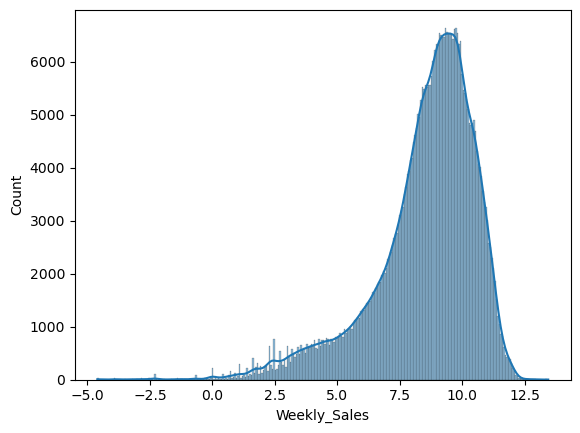

In [33]:
sns.histplot(df['Weekly_Sales'], kde=True)
plt.show()

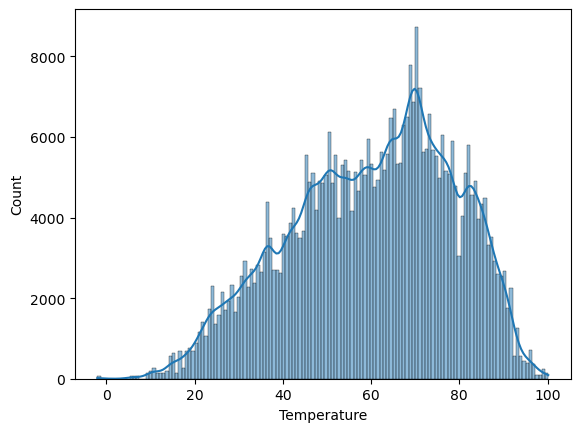

In [34]:
sns.histplot(df['Temperature'], kde=True)
plt.show()

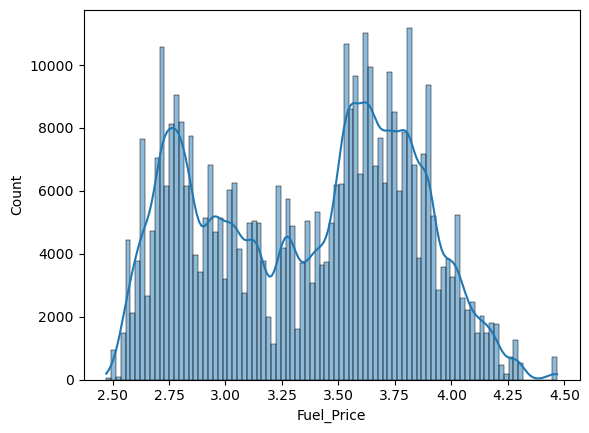

In [35]:
sns.histplot(df['Fuel_Price'], kde=True)
plt.show()

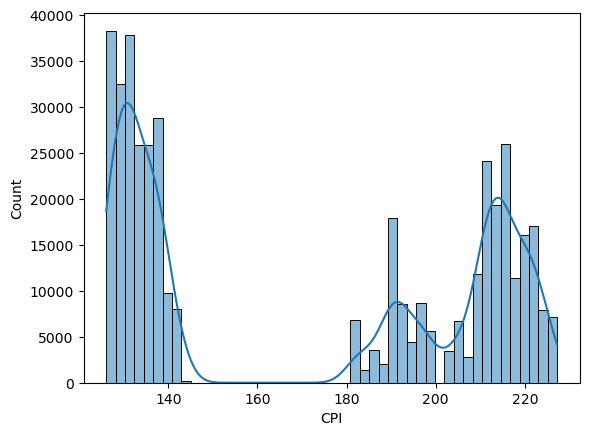

In [36]:
sns.histplot(df['CPI'], kde=True)
plt.show()

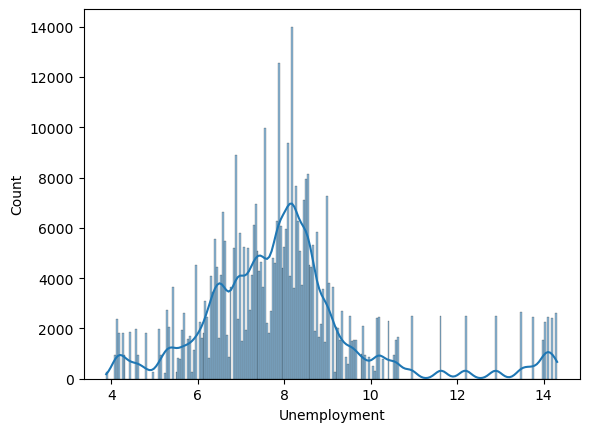

In [37]:
sns.histplot(df['Unemployment'], kde=True)
plt.show()

- **Weekly Sales is left-skewed.**

- **CPI and Unemployment have visible spread differences.**

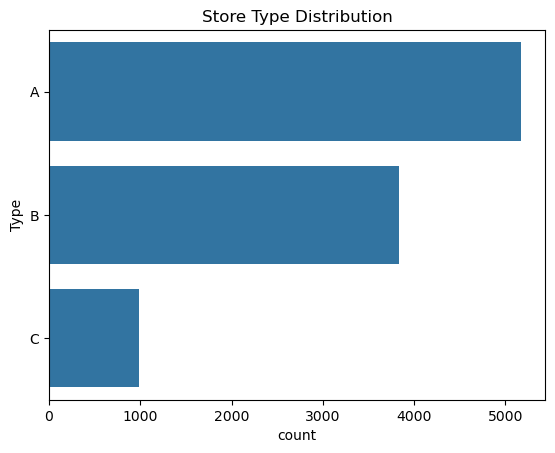

In [38]:
sns.countplot(df_sampled['Type'])
plt.title("Store Type Distribution")
plt.show()


- Type A stores dominate in number.

### Bivariate Analysis

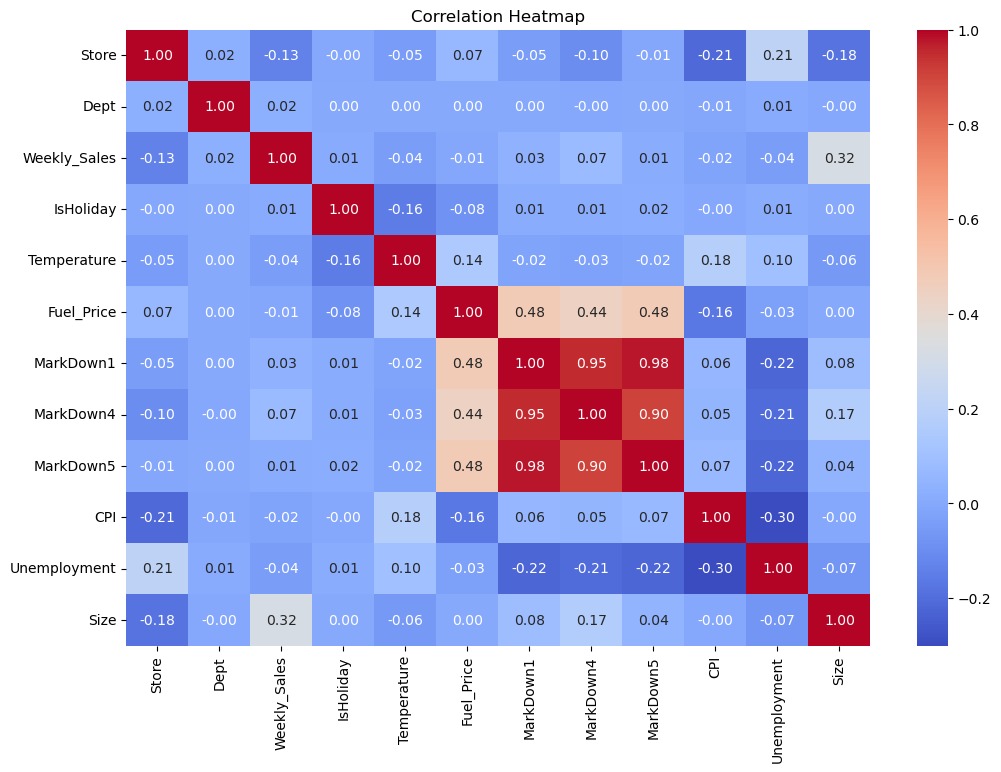

In [39]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.drop(['Date','Type'], axis=1).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


- Weekly_Sales has positive correlation with Size, MarkDown features.

- Weak negative correlation with Unemployment and CPI.

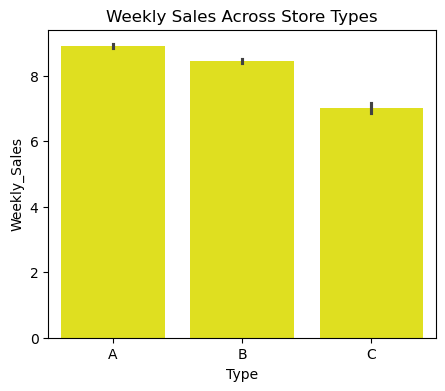

In [40]:
plt.figure(figsize=(5, 4))
sns.barplot(x='Type', y='Weekly_Sales', data=df_sampled, color="yellow")
plt.title("Weekly Sales Across Store Types")
plt.show()

- **Type A stores tend to have higher weekly sales, possibly due to larger size.**

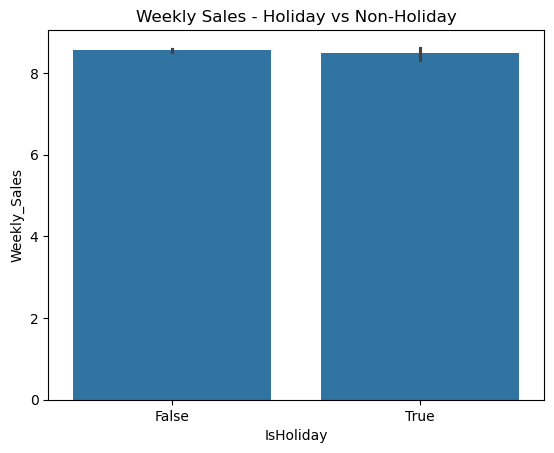

In [41]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df_sampled)
plt.title("Weekly Sales - Holiday vs Non-Holiday")
plt.show()


- Sales not increase during holidays — valuable for planning inventory.

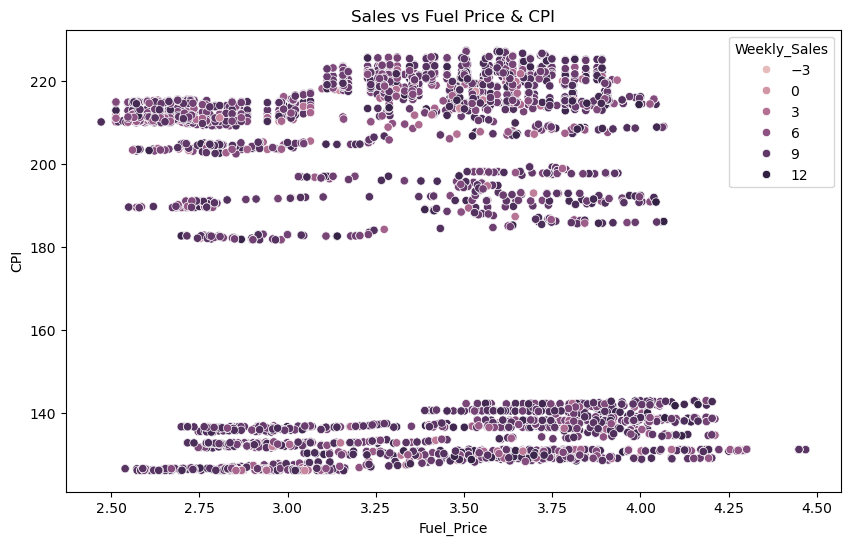

In [42]:
fig = plt.figure(figsize=(10, 6))
sns.scatterplot(x = df_sampled['Fuel_Price'], y = df_sampled['CPI'], hue = df_sampled['Weekly_Sales'])
plt.title("Sales vs Fuel Price & CPI")
plt.show()


### Treat Outliers

In [43]:
numerical_columns = df.select_dtypes(include=np.number).columns
numerical_columns

Index(['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size'],
      dtype='object')

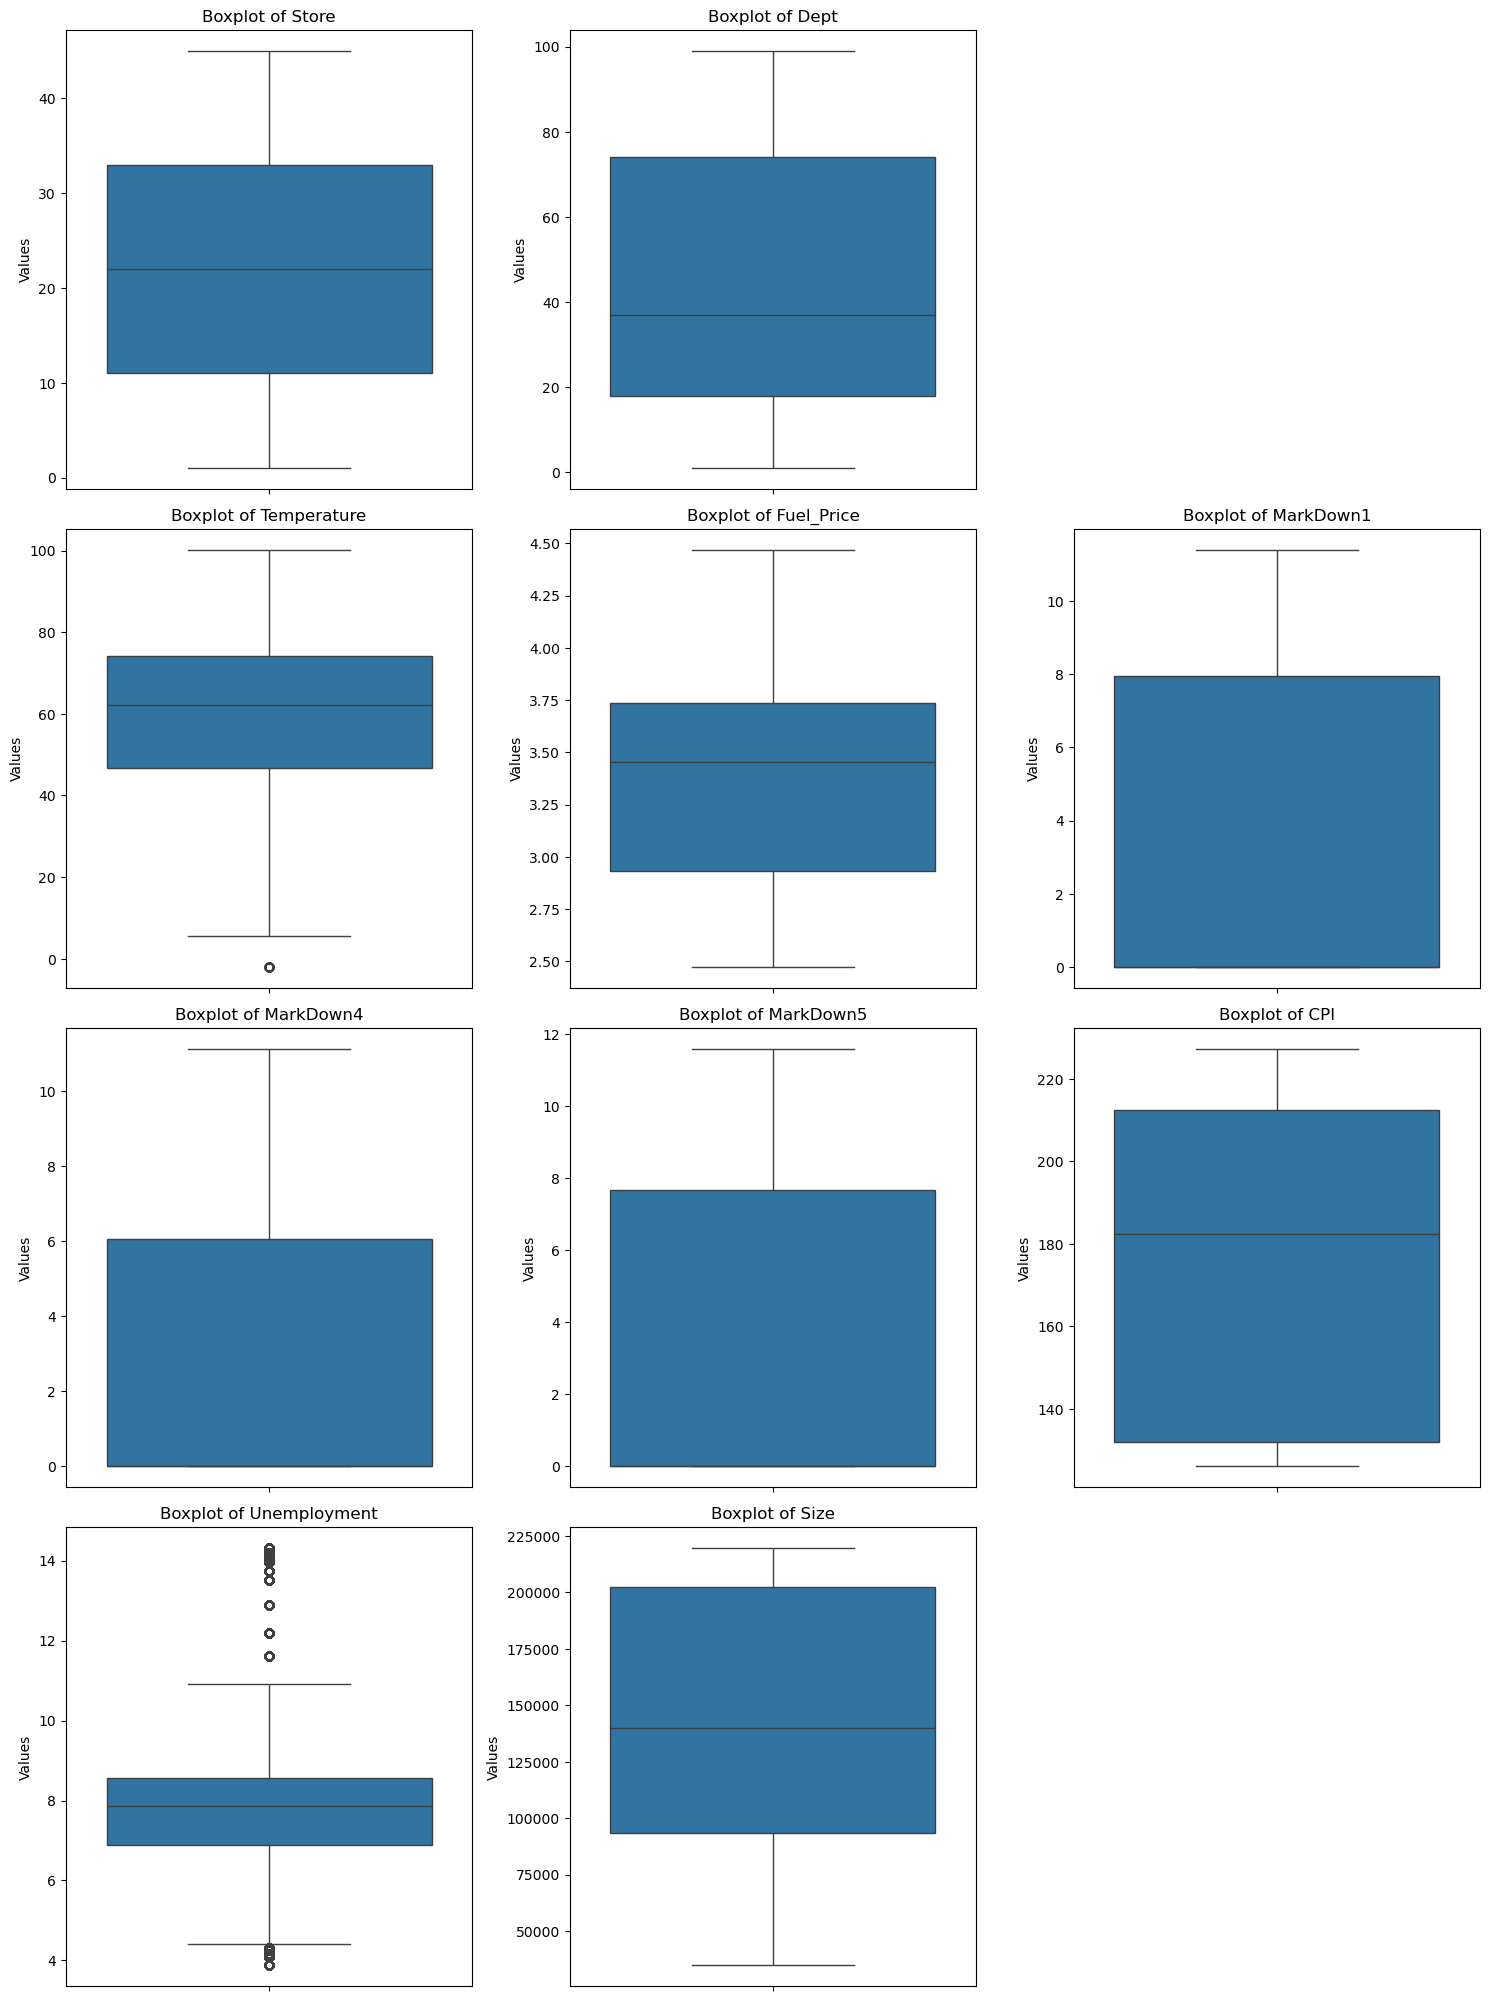

In [44]:
num_cols = len(numerical_columns)
plt.figure(figsize=(15, 5 * num_cols))
for i, col in enumerate(numerical_columns, 1):
    if col == "Weekly_Sales":
        continue
    plt.subplot(num_cols, 3, i)
    sns.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

In [45]:
for col in ['Unemployment']:
    q_low = df[col].quantile(0.25)
    q_hi = df[col].quantile(0.75)
    df[col] = np.clip(df[col], q_low, q_hi)


**Remove the outliers**

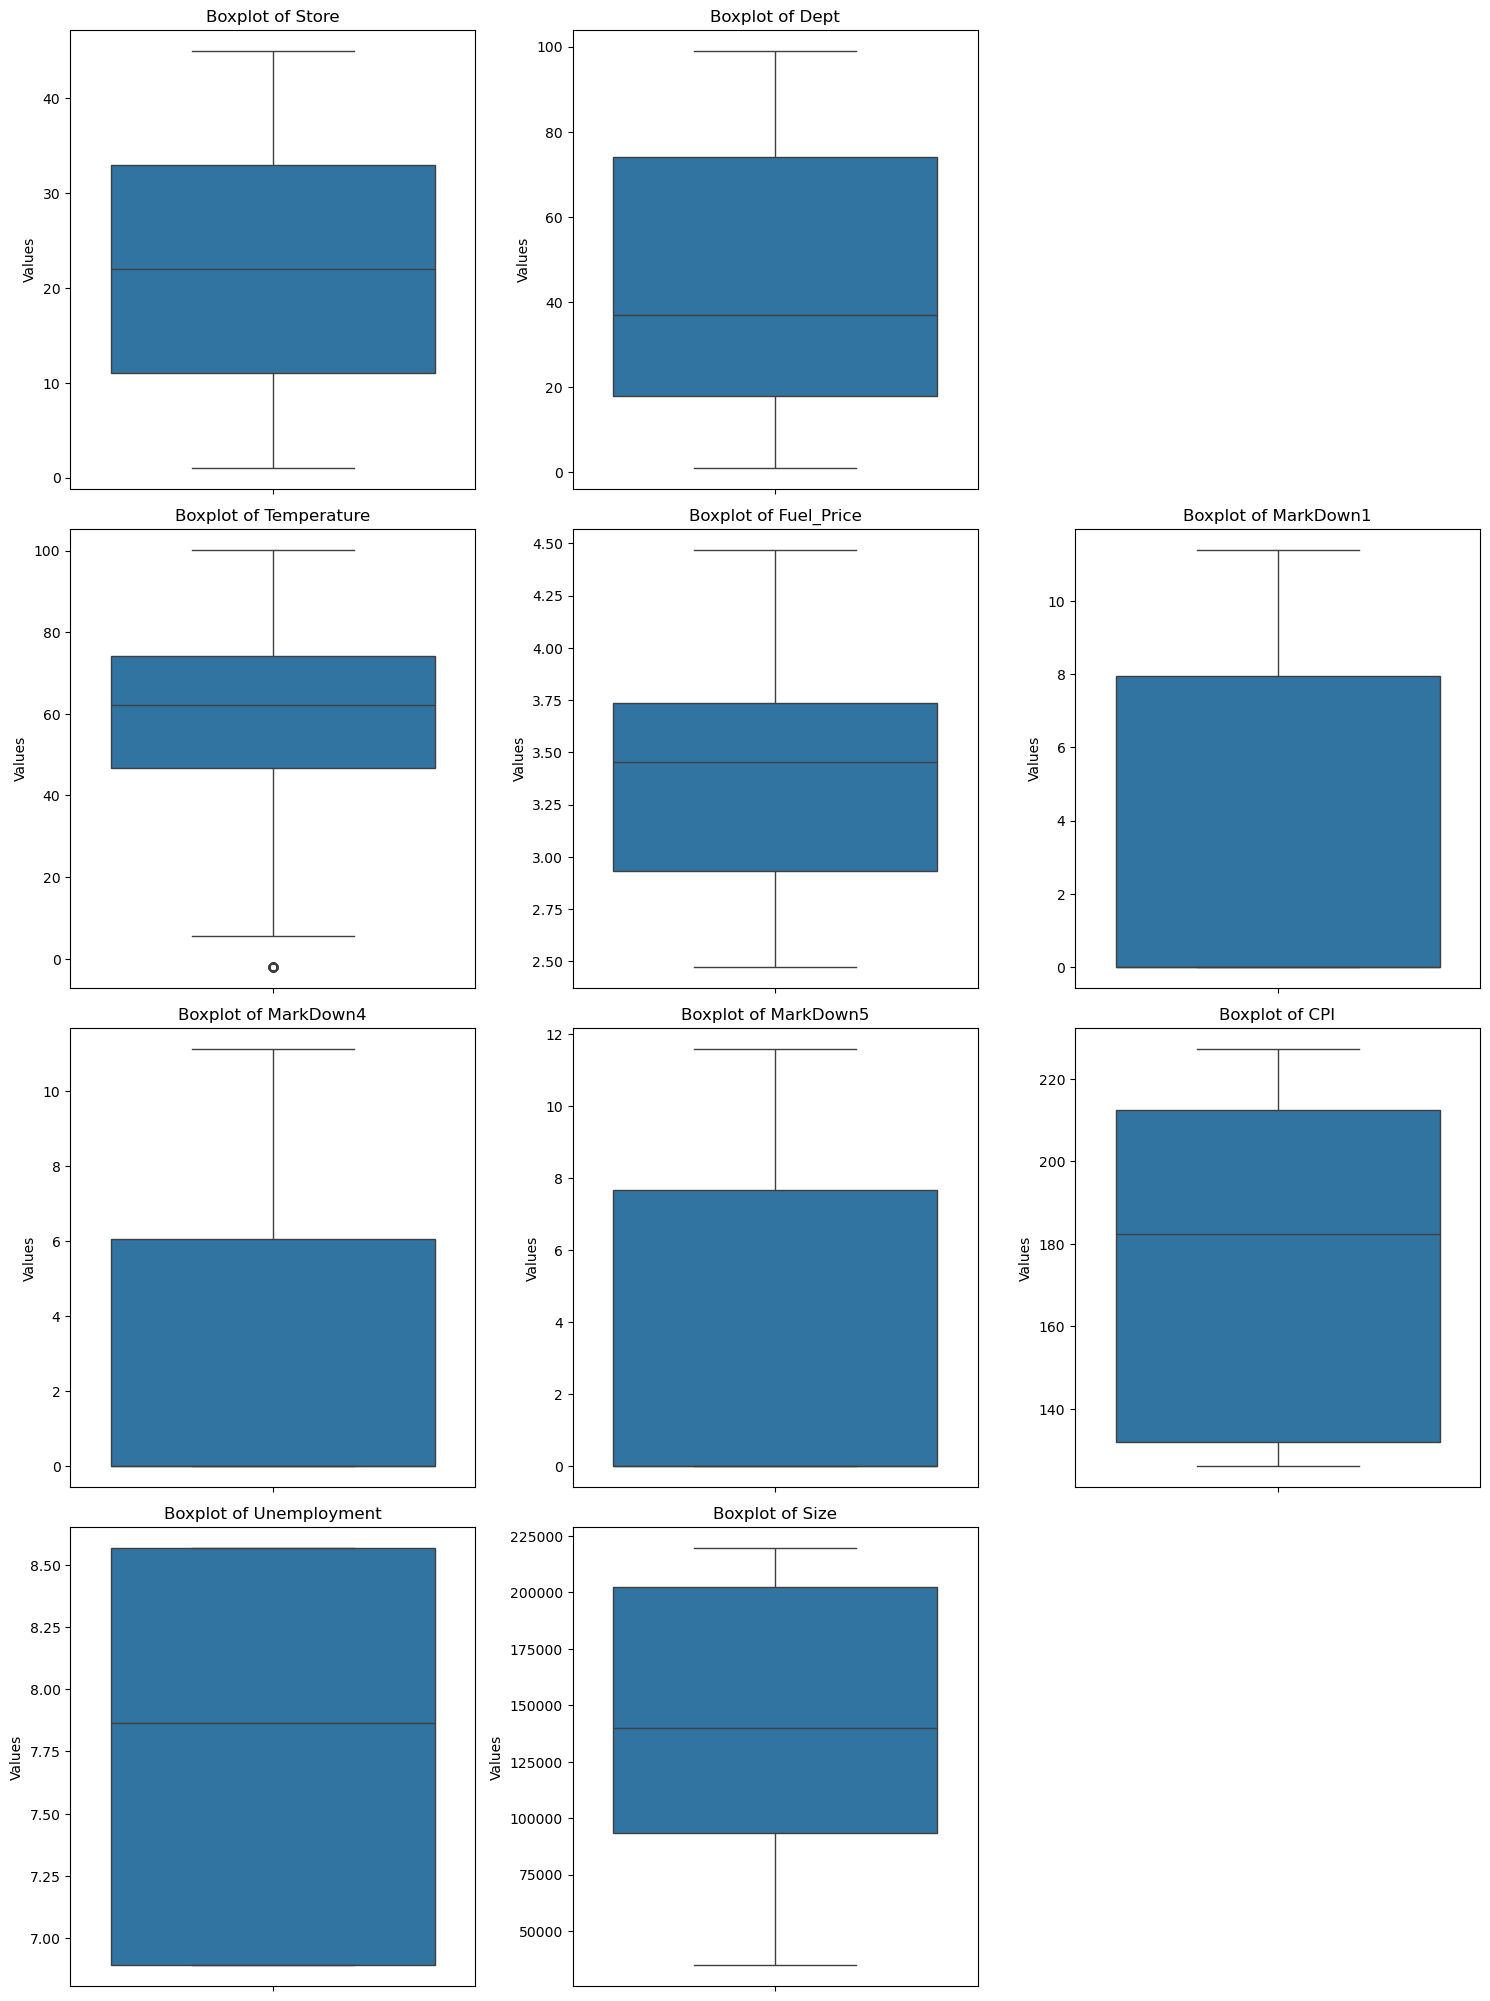

In [46]:
num_cols = len(numerical_columns)
plt.figure(figsize=(15, 5 * num_cols))
for i, col in enumerate(numerical_columns, 1):
    if col == "Weekly_Sales":
        continue
    plt.subplot(num_cols, 3, i)
    sns.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

## Feature Engineering

Create additional features such as date-based components.

In [47]:
# Extract date features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day

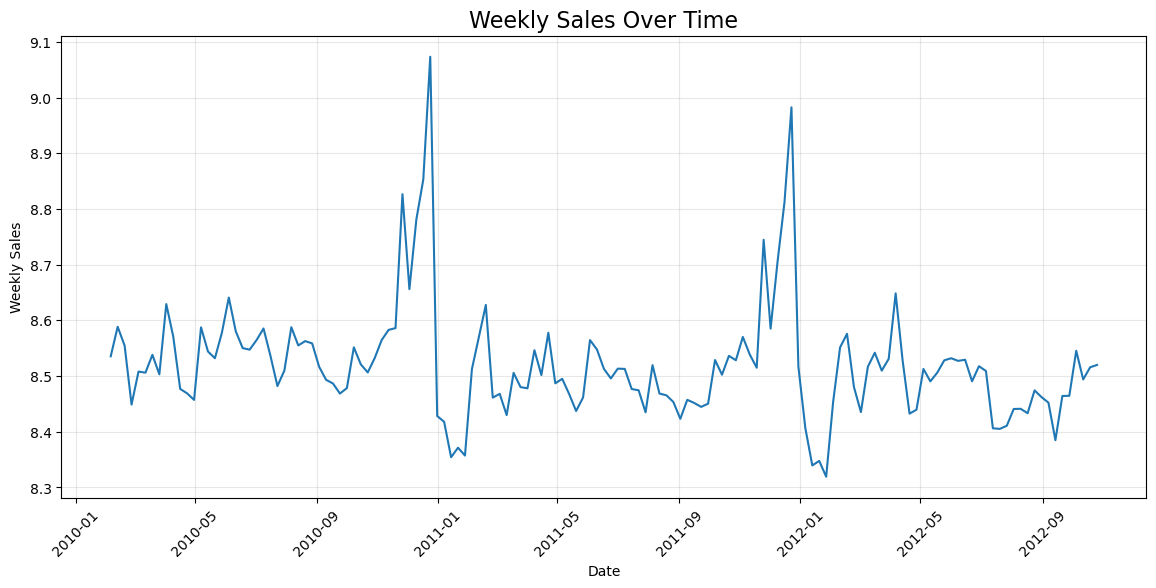

In [48]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Weekly_Sales', data=df, ci=None) 
plt.title('Weekly Sales Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)
plt.show()

In [49]:
df.drop(['Date'], axis=1, inplace = True)

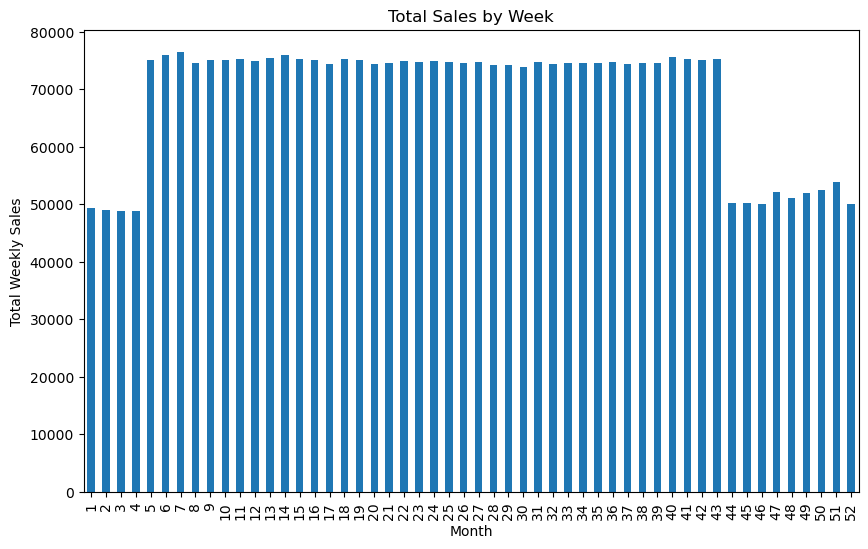

In [50]:
monthly_sales = df.groupby('Week')['Weekly_Sales'].sum()
monthly_sales.plot(kind='bar', figsize=(10,6), title='Total Sales by Week')
plt.xlabel('Month')
plt.ylabel('Total Weekly Sales')
plt.show()

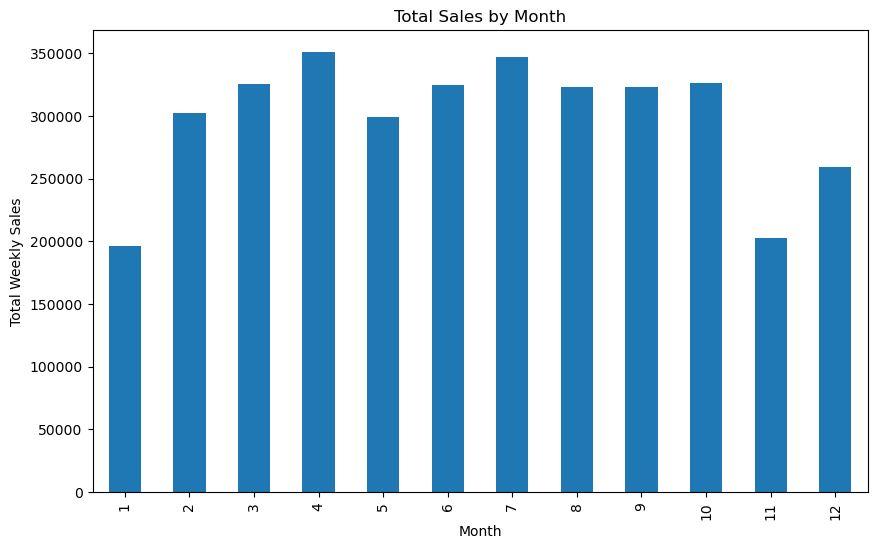

In [51]:
monthly_sales = df.groupby('Month')['Weekly_Sales'].sum()
monthly_sales.plot(kind='bar', figsize=(10,6), title='Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Weekly Sales')
plt.show()


## Encoding, Scaling and VIF

- **Label Encoding:** Used for `IsHoliday` and `Type` since they are categorical.
- Define the target (`Weekly_Sales`) and features
- **Standard Scaling:** Applied `StandardScaler` to normalize numerical features (`Weekly Sales`, `Temperature`, `Fuel Price`, etc.) to improve ML model performance.
- 
**VIF Calculation:**- Measures multicollinearity among numerical variables.
- High VIF values (>10) indicate strong multicollinearity, requiring feature selection.

In [52]:
n_data = df.copy()

In [53]:
n_data.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week,Day
0,1,1,10.123607,False,42.31,2.572,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,5
1,1,1,10.737255,True,38.51,2.548,0.0,0.0,0.0,211.242170,8.106,A,151315,2010,2,6,12
2,1,1,10.635748,False,39.93,2.514,0.0,0.0,0.0,211.289143,8.106,A,151315,2010,2,7,19
3,1,1,9.873211,False,46.63,2.561,0.0,0.0,0.0,211.319643,8.106,A,151315,2010,2,8,26
4,1,1,9.990944,False,46.50,2.625,0.0,0.0,0.0,211.350143,8.106,A,151315,2010,3,9,5


In [54]:
# Encoding categorical variables
label_encoder = LabelEncoder()
n_data['IsHoliday'] = label_encoder.fit_transform(n_data['IsHoliday'])
n_data['Type'] = label_encoder.fit_transform(n_data['Type'])

In [55]:
n_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420212 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         420212 non-null  int64  
 1   Dept          420212 non-null  int64  
 2   Weekly_Sales  420212 non-null  float64
 3   IsHoliday     420212 non-null  int64  
 4   Temperature   420212 non-null  float64
 5   Fuel_Price    420212 non-null  float64
 6   MarkDown1     420212 non-null  float64
 7   MarkDown4     420212 non-null  float64
 8   MarkDown5     420212 non-null  float64
 9   CPI           420212 non-null  float64
 10  Unemployment  420212 non-null  float64
 11  Type          420212 non-null  int32  
 12  Size          420212 non-null  int64  
 13  Year          420212 non-null  int32  
 14  Month         420212 non-null  int32  
 15  Week          420212 non-null  UInt32 
 16  Day           420212 non-null  int32  
dtypes: UInt32(1), float64(8), int32(4), int64(4)
memory u

In [56]:
X = n_data.drop(columns=['Weekly_Sales'])
y = n_data['Weekly_Sales']

In [57]:
# sampled_data = n_data.sample(n=100000, random_state=42)  # Adjust size as needed
# X = sampled_data.drop(columns=['Weekly_Sales'])
# y = sampled_data['Weekly_Sales']

In [58]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(X_scaled.head())

      Store     Dept  IsHoliday  Temperature  Fuel_Price  MarkDown1  \
0 -1.657562 -1.41734  -0.275079    -0.963831   -1.720520  -0.725563   
1 -1.657562 -1.41734   3.635321    -1.169817   -1.772863  -0.725563   
2 -1.657562 -1.41734  -0.275079    -1.092844   -1.847014  -0.725563   
3 -1.657562 -1.41734  -0.275079    -0.729657   -1.744510  -0.725563   
4 -1.657562 -1.41734  -0.275079    -0.736704   -1.604931  -0.725563   

   MarkDown4  MarkDown5       CPI  Unemployment      Type      Size     Year  \
0   -0.65682  -0.742136  1.018422      0.486075 -0.884596  0.238802 -1.21528   
1   -0.65682  -0.742136  1.022146      0.486075 -0.884596  0.238802 -1.21528   
2   -0.65682  -0.742136  1.023345      0.486075 -0.884596  0.238802 -1.21528   
3   -0.65682  -0.742136  1.024124      0.486075 -0.884596  0.238802 -1.21528   
4   -0.65682  -0.742136  1.024903      0.486075 -0.884596  0.238802 -1.21528   

      Month      Week       Day  
0 -1.371979 -1.471715 -1.219483  
1 -1.371979 -1.401056 -0

In [59]:
X_scaled.isnull().sum()

Store           0
Dept            0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Month           0
Week            0
Day             0
dtype: int64

In [60]:
# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

vif_data

,Feature,VIF
0,Store,1.233264
1,Dept,1.000753
2,IsHoliday,1.131346
3,Temperature,1.325884
4,Fuel_Price,5.450042
5,MarkDown1,58.587610
6,MarkDown4,14.308798
7,MarkDown5,32.080730
8,CPI,1.394512
9,Unemployment,1.385270


In [61]:
X_scaled.drop(['Month','Week','Day'], axis=1, inplace = True)

In [62]:
X_scaled.drop(['MarkDown1','MarkDown4'], axis=1, inplace = True)

- Drop highly corr columns

In [63]:
# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

vif_data

,Feature,VIF
0,Store,1.177098
1,Dept,1.000694
2,IsHoliday,1.037717
3,Temperature,1.130010
4,Fuel_Price,3.852706
5,MarkDown5,3.683100
6,CPI,1.362220
7,Unemployment,1.326133
8,Type,3.033218
9,Size,2.998762


## Model Building & Machine Learning

In this section, we build a baseline machine learning model to forecast weekly sales. We will:


- Split the data into training and testing sets
- Train a model using RandomForestregressor
- Evaluate the model performance using R²

In [64]:
# Split Data into Train & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [65]:
# Train Model
rf = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)


y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)


train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)



In [66]:
train_r2

0.8538124630661189

In [67]:
test_r2

0.8492473873150883

## Sales Prediction 

In [68]:
custom_data = pd.DataFrame({
    'Store': [1],  
    'Dept': [1],  
    'IsHoliday': [0],  
    'Temperature': [50], 
    'Fuel_Price': [3], 
    'MarkDown1': [0], 
    'MarkDown4': [0],
    'MarkDown5': [0], 
    'CPI': [100],
    'Unemployment': [6], 
    'Type': [0],  
    'Size': [10000],  
    'Year': [2012],  
    'Month': [1],  
    'Week': [1],  
    'Day': [1]  
   
})

In [69]:
custom_data_scaled = scaler.transform(custom_data)
custom_data_scaled

array([[-1.65756196, -1.4173397 , -0.27507884, -0.54698012, -0.78707921,
        -0.72556327, -0.65681951, -0.74213643, -1.81838955, -2.59112727,
        -0.88459568, -2.07810253,  1.29445244, -1.6802978 , -1.75435133,
        -1.67647947]])

In [70]:
custom_data_scaled = pd.DataFrame(custom_data_scaled, columns=X.columns)
custom_data_scaled

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week,Day
0,-1.657562,-1.41734,-0.275079,-0.54698,-0.787079,-0.725563,-0.65682,-0.742136,-1.81839,-2.591127,-0.884596,-2.078103,1.294452,-1.680298,-1.754351,-1.676479


In [71]:
# Remove columns that were dropped during training
custom_data_scaled = custom_data_scaled.drop(['Month', 'Week', 'Day', 'MarkDown1', 'MarkDown4'], axis=1)

In [72]:
# Make the prediction
predicted_sales = rf.predict(custom_data_scaled)


In [73]:
# Inverse transform the prediction to get the original scale
predicted_sales = np.exp(predicted_sales)
print("Predicted sale is: ",predicted_sales)

Predicted sale is:  [9837.30355871]
